# Multi-omics integration & machine learning (toy example)

Obiettivi del notebook:
- Simulare un piccolo dataset **multi-omics** (trascrittomica + metabolomica) con esposizione ambientale.
- Mostrare un esempio di **early integration** (concatenazione delle matrici).
- Esplorare i dati con **PCA**.
- Esempio di integrazione basata su **correlazioni gene–metabolita**.
- Addestrare un semplice **Random Forest** per classificare il livello di esposizione.

_Tutti i dati sono simulati per scopi didattici._

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

%matplotlib inline
np.random.seed(8)

## 1. Simulazione di un dataset multi-omics + esposizione

Immaginiamo:
- 60 campioni totali (es. individui o organismi).
- 30 **basso inquinamento** (CTRL) e 30 **alta esposizione** (HIGH).
- 100 geni (trascrittomica) e 50 metaboliti (metabolomica).
- Un piccolo sottoinsieme di geni/metaboliti è davvero associato all'esposizione.


In [2]:
n_samples = 60
n_ctrl = 30
n_high = 30
n_genes = 100
n_mets = 50

sample_ids = [f"S{i+1:03d}" for i in range(n_samples)]
exposure = np.array([0]*n_ctrl + [1]*n_high)  # 0 = low, 1 = high
exposure_labels = np.where(exposure == 0, "LOW", "HIGH")
exposure_series = pd.Series(exposure_labels, index=sample_ids, name="ExposureGroup")

# Trascrittomica: log2(expression) ~ N(0, 1)
X_rna = np.random.normal(loc=0.0, scale=1.0, size=(n_samples, n_genes))
# Metabolomica: log10(intensità) ~ N(5, 0.5)
X_met = np.random.normal(loc=5.0, scale=0.5, size=(n_samples, n_mets))

# Geni/metaboliti realmente associati all'esposizione
signal_genes = np.arange(0, 10)        # primi 10 geni
signal_mets = np.arange(0, 8)          # primi 8 metaboliti

for g in signal_genes:
    X_rna[exposure == 1, g] += 1.2     # up-regolati nel gruppo HIGH
for m in signal_mets:
    X_met[exposure == 1, m] += 0.8     # intensità aumentata nel gruppo HIGH

gene_names = [f"G_{i+1:03d}" for i in range(n_genes)]
met_names = [f"M_{i+1:03d}" for i in range(n_mets)]

rna_df = pd.DataFrame(X_rna, index=sample_ids, columns=gene_names)
met_df = pd.DataFrame(X_met, index=sample_ids, columns=met_names)

rna_df.head()

,G_001,G_002,G_003,G_004,G_005,G_006,G_007,G_008,G_009,G_010,...,G_091,G_092,G_093,G_094,G_095,G_096,G_097,G_098,G_099,G_100
S001,0.091205,1.091283,-1.946970,-1.386350,-2.296492,2.409834,1.727836,2.204556,0.794828,0.976421,...,0.496228,-1.331667,-2.190570,-0.436072,2.545087,1.150081,0.084445,2.486248,-0.194355,-0.186213
S002,0.853863,0.307379,-0.072242,-0.468848,-0.065439,1.052611,-1.309633,-0.668726,1.341374,2.531357,...,1.331433,-0.827578,1.934943,-1.274892,-0.656888,1.513228,-2.184230,0.798911,-1.274588,-1.172944
S003,0.029556,-0.074043,0.542831,-0.168883,-0.320259,-1.194553,0.261458,-2.508171,0.622154,0.192224,...,0.133299,0.698210,-0.410673,1.959167,-0.494360,0.188155,1.096226,0.074107,-2.414503,0.708197
S004,0.255015,-0.684429,1.147898,1.065936,-0.537271,-1.476566,-1.808385,-0.189663,-0.592324,-0.144804,...,0.360994,-0.473022,-0.670003,0.770305,0.562687,-0.993338,-0.044764,-0.692453,0.211384,0.710282
S005,0.969231,-0.413857,0.274788,-0.787225,0.832671,0.293128,-0.270898,0.387550,-1.793781,-1.004802,...,1.361944,-0.615172,1.344216,0.137802,-1.778596,-1.654343,0.414983,1.568882,-0.103683,-0.372217


## 2. QC qualitativo: distribuzione delle intensità per omica

Guardiamo rapidamente la distribuzione delle espressioni geniche e delle intensità metaboliche.

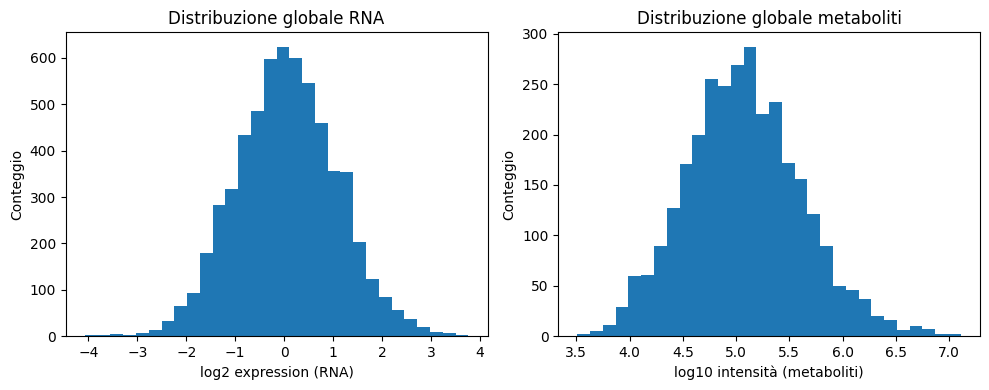

In [3]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(rna_df.values.ravel(), bins=30)
plt.xlabel("log2 expression (RNA)")
plt.ylabel("Conteggio")
plt.title("Distribuzione globale RNA")

plt.subplot(1,2,2)
plt.hist(met_df.values.ravel(), bins=30)
plt.xlabel("log10 intensità (metaboliti)")
plt.ylabel("Conteggio")
plt.title("Distribuzione globale metaboliti")

plt.tight_layout()
plt.show()

## 3. Early integration: concatenare le matrici omiche

Prima di concatenare, è buona pratica riportare le feature su scale comparabili (z-score per colonna).

In [4]:
def zscore_df(df: pd.DataFrame) -> pd.DataFrame:
    return (df - df.mean(axis=0)) / df.std(axis=0, ddof=1)

rna_z = zscore_df(rna_df)
met_z = zscore_df(met_df)

# Concatenazione orizzontale (early integration)
multi_omics_df = pd.concat([rna_z.add_prefix("RNA_"), met_z.add_prefix("MET_")], axis=1)
multi_omics_df.head()

,RNA_G_001,RNA_G_002,RNA_G_003,RNA_G_004,RNA_G_005,RNA_G_006,RNA_G_007,RNA_G_008,RNA_G_009,RNA_G_010,...,MET_M_041,MET_M_042,MET_M_043,MET_M_044,MET_M_045,MET_M_046,MET_M_047,MET_M_048,MET_M_049,MET_M_050
S001,-0.534185,0.454377,-2.449257,-1.376624,-2.451102,1.515722,1.104976,1.336736,0.194555,0.402145,...,-0.137315,1.305115,2.225090,0.904455,-0.761917,-1.308495,-1.531656,-0.815644,-0.806505,0.014599
S002,0.214377,-0.230880,-0.566466,-0.686083,-0.468819,0.208251,-1.820723,-0.969367,0.679655,1.729861,...,0.886780,0.140825,-0.999314,-1.002573,0.428573,1.166977,1.099651,0.671744,-1.121218,-0.725260
S003,-0.594695,-0.564304,0.051253,-0.460320,-0.695225,-1.956539,-0.307444,-2.445710,0.041295,-0.267459,...,0.488197,0.635287,-0.544800,-0.317860,0.403138,-0.835488,-1.502640,-0.235123,0.659010,1.173986
S004,-0.373403,-1.097878,0.658922,0.469045,-0.888040,-2.228214,-2.301122,-0.584870,-1.036643,-0.555238,...,0.313377,0.814851,0.461573,0.387459,0.376421,-0.524733,0.811325,-0.269061,-1.602129,1.309795
S005,0.327613,-0.861355,-0.217943,-0.925704,0.329149,-0.523392,-0.820211,-0.121597,-2.103025,-1.289566,...,-0.473439,-0.746440,-0.456852,-0.266129,0.276803,-0.686211,-0.049084,0.467203,-0.564378,0.350379


## 4. PCA sull'insieme integrato

Applichiamo una PCA (via SVD) sui dati integrati per vedere se i campioni LOW vs HIGH tendono a separarsi nelle prime componenti.

In [5]:
# Matrice campioni x feature
X = multi_omics_df.values
# Centro le feature (già z-scored, ma centriamo ancora per sicurezza)
X_centered = X - X.mean(axis=0, keepdims=True)

# SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
PCs = U[:, :2] * S[:2]
pca_df = pd.DataFrame(PCs, index=sample_ids, columns=["PC1", "PC2"])
pca_df.head()

,PC1,PC2
S001,-2.879679,1.165742
S002,-2.177463,3.079385
S003,-2.977612,-0.098240
S004,-3.483952,-4.789346
S005,-2.843632,0.148630


### Plot PC1 vs PC2 colorando per gruppo di esposizione

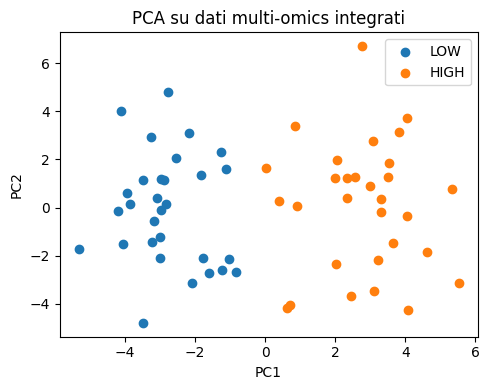

In [6]:
plt.figure(figsize=(5,4))
for grp, color in [("LOW", "blue"), ("HIGH", "red")]:
    idx = (exposure_series == grp)
    plt.scatter(pca_df.loc[idx, "PC1"], pca_df.loc[idx, "PC2"], label=grp)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA su dati multi-omics integrati")
plt.legend()
plt.tight_layout()
plt.show()

Si può discutere in aula:
- quanto i gruppi siano separati nelle prime componenti,
- il ruolo del numero di feature e del rapporto feature/campioni.

## 5. Integrazione basata su correlazioni gene–metabolita

Come esempio, prendiamo un gene "esposto" e vediamo quali metaboliti sono più correlati ad esso.

In [7]:
gene_example = "G_001"  # uno dei primi geni, che abbiamo reso dipendente da esposizione
g_vals = rna_df[gene_example]
corrs = []
for met in met_names:
    r, pval = stats.pearsonr(g_vals.values, met_df[met].values)
    corrs.append({"metabolite": met, "r": r, "pval": pval})
corr_df = pd.DataFrame(corrs).sort_values("r", ascending=False)
corr_df.head(10)

,metabolite,r,pval
4,M_005,0.285057,0.027271
0,M_001,0.280448,0.029976
1,M_002,0.243699,0.060604
2,M_003,0.238734,0.066212
24,M_025,0.171043,0.191324
9,M_010,0.159580,0.223255
43,M_044,0.153215,0.242505
5,M_006,0.140643,0.283793
6,M_007,0.136150,0.299612
26,M_027,0.131946,0.314919


Possiamo anche fare uno scatter plot gene vs metabolita più correlato.

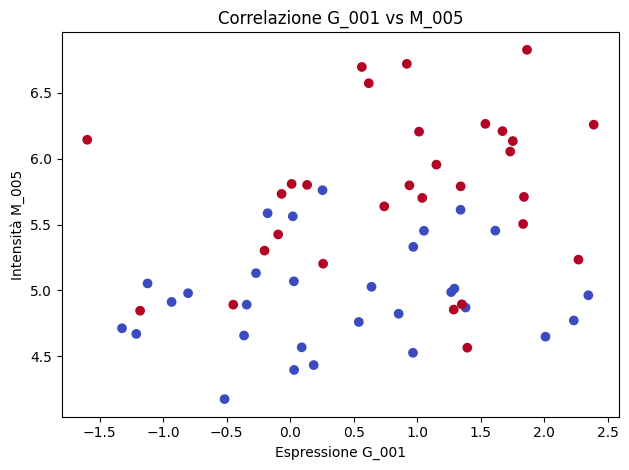

In [8]:
top_met = corr_df.iloc[0]["metabolite"]
plt.scatter(g_vals, met_df[top_met], c=exposure, cmap="coolwarm")
plt.xlabel(f"Espressione {gene_example}")
plt.ylabel(f"Intensità {top_met}")
plt.title(f"Correlazione {gene_example} vs {top_met}")
plt.tight_layout()
plt.show()

## 6. Modello di machine learning supervisionato (Random Forest)

Obiettivo: classificare i campioni in **LOW** vs **HIGH** esposizione usando tutte le feature multi-omics integrate.

Workflow:
1. Split train/test.
2. Addestramento di un `RandomForestClassifier`.
3. Valutazione con accuracy, matrice di confusione e ROC-AUC.


In [9]:
X = multi_omics_df.values
y = exposure  # 0 = LOW, 1 = HIGH

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("Accuracy:", round(acc, 3))
print("ROC-AUC:", round(auc, 3))
print("Confusion matrix:\n", cm)

Accuracy: 1.0
ROC-AUC: 1.0
Confusion matrix:
 [[9 0]
 [0 9]]


### ROC curve

Visualizziamo la curva ROC e l'area sotto la curva.

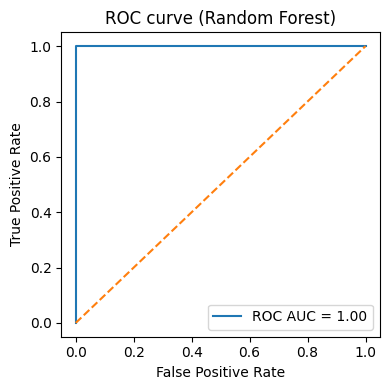

In [10]:
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (Random Forest)")
plt.legend()
plt.tight_layout()
plt.show()

## 7. Interpretazione del modello: feature importance

Estraiamo le feature più importanti secondo la Random Forest e vediamo se sono geni o metaboliti.

In [11]:
feature_names = multi_omics_df.columns
importances = clf.feature_importances_
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances,
})
imp_df = imp_df.sort_values("importance", ascending=False)
imp_df.head(15)

,feature,importance
107,MET_M_008,0.067477
102,MET_M_003,0.066931
8,RNA_G_009,0.066439
100,MET_M_001,0.058668
103,MET_M_004,0.047652
1,RNA_G_002,0.041650
101,MET_M_002,0.039506
105,MET_M_006,0.036396
104,MET_M_005,0.033665
4,RNA_G_005,0.030137


Possiamo separare l'importanza aggregata per layer (RNA vs MET).

In [12]:
imp_df["layer"] = imp_df["feature"].apply(lambda x: x.split("_")[0])
imp_by_layer = imp_df.groupby("layer")["importance"].sum()
imp_by_layer

layer
MET    0.468913
RNA    0.531087
Name: importance, dtype: float64

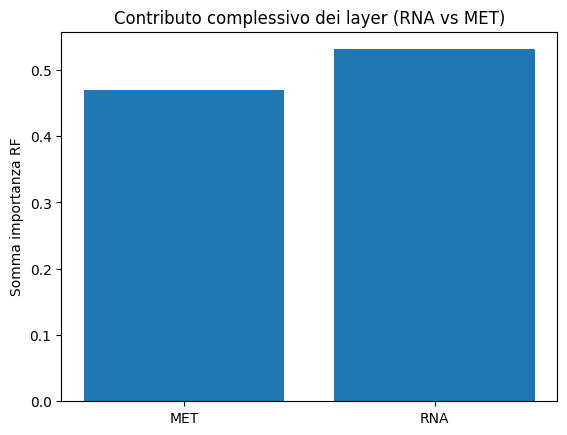

In [13]:
plt.bar(imp_by_layer.index, imp_by_layer.values)
plt.ylabel("Somma importanza RF")
plt.title("Contributo complessivo dei layer (RNA vs MET)")
plt.show()

In una discussione in aula si può collegare questo a:
- quali livelli omici sembrano più informativi per la classificazione,
- quali geni/metaboliti emergono come candidati biomarcatori,
- rischi di overfitting quando #feature ≫ #campioni.

Questo notebook implementa un flusso didattico coerente con la Lecture 8:
- preprocessing e z-score,
- early integration,
- PCA,
- correlazioni inter-omiche,
- machine learning supervisionato + interpretazione delle feature.